In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import json
import re
from functools import partial
from io import StringIO
from pathlib import Path

import cinnabar.stats as cstats
import numpy as np
import pandas as pd
import requests
from QligFEP.analyze_FEP import FepReader
from scipy import stats

In [3]:
from typing import Union
from rdkit import Chem
import matplotlib.pyplot as plt
from openff.toolkit import Molecule
from QligFEP.chemIO import MoleculeIO
from QligFEP.CLI.utils import get_avail_restraint_methods
from QligFEP.restraints.restraint_setter import RestraintSetter


def calculate_restraint_similarity(
    ligand1: Union[Molecule, Chem.Mol, str, Path],
    ligand2: Union[Molecule, Chem.Mol, str, Path],
    restraint_method: str = "hybridization_p",
) -> dict[int, int]:
    """Apply the restraints according to the specified method and calculate several similarity
    scores between them.

    Args:
        ligand1: First ligand (RDKit Mol or custom Molecule object).
        ligand2: Second ligand (RDKit Mol or custom Molecule object).
        restraint_method: Chosen method for setting the ligand restraints. Defaults to "hybridization_p".

    Returns: # TODO
        The similarity score between the two ligands, calculated as the squared number of restrained atoms
        divided by the product of the number of atoms in each ligand.
    """
    ligand1 = RestraintSetter.input_to_small_molecule_component(ligand1)
    ligand2 = RestraintSetter.input_to_small_molecule_component(ligand2)

    # Handle cases where a custom kartograf threshold is provided
    kartograf_thresh = 0.95
    if len(restraint_method.split("_")) == 3:
        kartograf_thresh = float(restraint_method.split("_")[2])
        restraint_method = "_".join(restraint_method.split("_")[:2])
        pass
    elif len(restraint_method.split("_")) > 3:
        raise ValueError(
            f"restraint_method should be of the form `method_permissiveness_krtgrfThresh`, got {restraint_method}"
        )

    # Check if the passed restraint method is available
    if restraint_method not in get_avail_restraint_methods():
        raise ValueError(
            f"restraint_method should be one of {get_avail_restraint_methods()}, got {restraint_method}"
        )
    elif restraint_method == "overlap":
        raise ValueError("Overlap method is not supported by this method yet, use `kartograf` instead.")
    rsetter = RestraintSetter(ligand1, ligand2, kartograf_thresh)

    # Set the restraints according to the chosen method
    if restraint_method == "kartograf":
        restraint_dict = rsetter.set_restraints(
            kartograf_native=True,  # other arguments ignored
        )
    else:
        atom_compare_method, permissiveness_lvl = restraint_method.split("_")
        if permissiveness_lvl == "p":
            # in this case, ignore_surround_atom_type is not needed
            params = {"strict_surround": False}
        elif permissiveness_lvl == "ls":
            params = {"strict_surround": True, "ignore_surround_atom_type": True}
        elif permissiveness_lvl == "strict":
            params = {"strict_surround": True, "ignore_surround_atom_type": False}
        restraint_dict = rsetter.set_restraints(atom_compare_method=atom_compare_method, **params)
        # logger.debug(f"Restraints set using {restraint_method} method. Parameters: {params}")

    # Calculate some metrics on the differences between the ligands: can we estimate the error?
    n_restrained = len(restraint_dict.keys())
    natoms_lig1 = ligand1.to_rdkit().GetNumHeavyAtoms()
    natoms_lig2 = ligand2.to_rdkit().GetNumHeavyAtoms()
    similarity = n_restrained**2 / (natoms_lig1 * natoms_lig2)
    atom_n_diff = abs(natoms_lig1 - natoms_lig2)
    unrestrained_bigger_mol = max(natoms_lig1, natoms_lig2) - n_restrained

    nRingsA = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand1.to_rdkit()))
    nRingsB = len(rsetter.atom_mapper.identify_and_enumerate_rings(ligand2.to_rdkit()))
    diff_rings = abs(nRingsA - nRingsB)
    return similarity, atom_n_diff, unrestrained_bigger_mol, diff_rings

In [4]:
all_dataframes = []

# JACS

## bace

2025-04-23 17:15:12 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.28_{0.1}^{0.46}$ (Kendall's $\tau$) RMSE = $1.75_{1.43}^{2.01}  \frac{kcal}{mol}$ MUE = $1.42_{1.13}^{1.71}  \frac{kcal}{mol}$


Crashes:  0


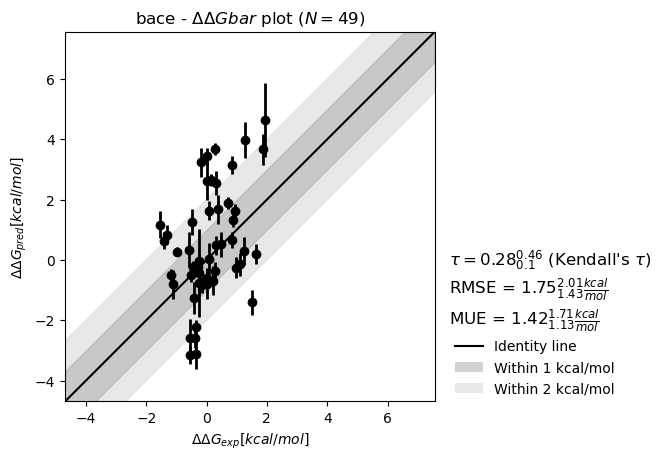

In [5]:
json_results = json.loads(Path("results/bace/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="bace",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [6]:
fep_names = {}

chemio = MoleculeIO("perturbations/bace/ligands.sdf")
network_dict = json.loads(Path("perturbations/bace/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cdk2

In [ ]:
json_results = json.loads(Path("results/cdk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiy. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oi9. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 32. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1oiu. Reindexed.
2025-04-23 16:28:37 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2

## jnk1

2025-04-23 16:28:40 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.35_{0.04}^{0.64}$ (Kendall's $\tau$) RMSE = $1.45_{1.08}^{1.83}  \frac{kcal}{mol}$ MUE = $1.17_{0.85}^{1.51}  \frac{kcal}{mol}$


Crashes:  0


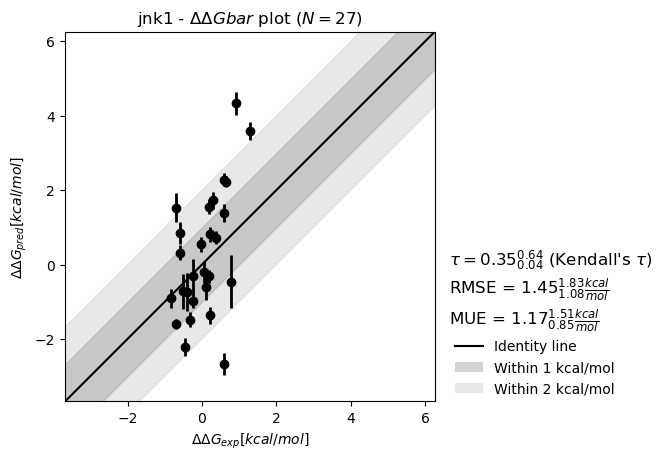

In [ ]:
json_results = json.loads(Path("results/jnk1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="jnk1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/jnk1/ligands.sdf")
network_dict = json.loads(Path("perturbations/jnk1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18626-1. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18628-1_flip. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18629-1. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18636-1. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18638-1. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 18659-1. Reindexed.
2025-04-23 16:28:41 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of

## mcl1

2025-04-23 16:28:45 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.19_{0.02}^{0.35}$ (Kendall's $\tau$) RMSE = $2.04_{1.55}^{2.61}  \frac{kcal}{mol}$ MUE = $1.55_{1.23}^{1.9}  \frac{kcal}{mol}$


Crashes:  0


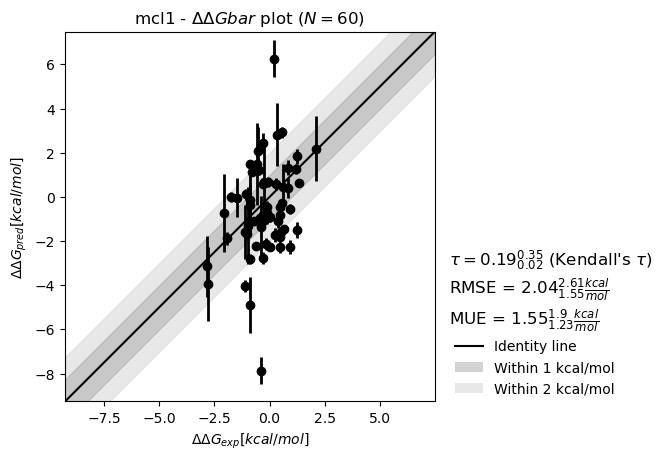

In [ ]:
json_results = json.loads(Path("results/mcl1/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="mcl1",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/mcl1/ligands.sdf")
network_dict = json.loads(Path("perturbations/mcl1/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 23. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 26. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 27. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 28. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 29. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 30_flip. Reindexed.
2025-04-23 16:28:46 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 31

## p38

2025-04-23 16:28:50 | WARNING  | QligFEP.analyze_FEP:create_ddG_plot:535 - Dropping FEPs with nan values: ['FEP_2k_2u']


2025-04-23 16:28:53 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.58_{0.44}^{0.71}$ (Kendall's $\tau$) RMSE = $1.50_{1.22}^{1.75}  \frac{kcal}{mol}$ MUE = $1.22_{0.98}^{1.47}  \frac{kcal}{mol}$


Crashes:  1


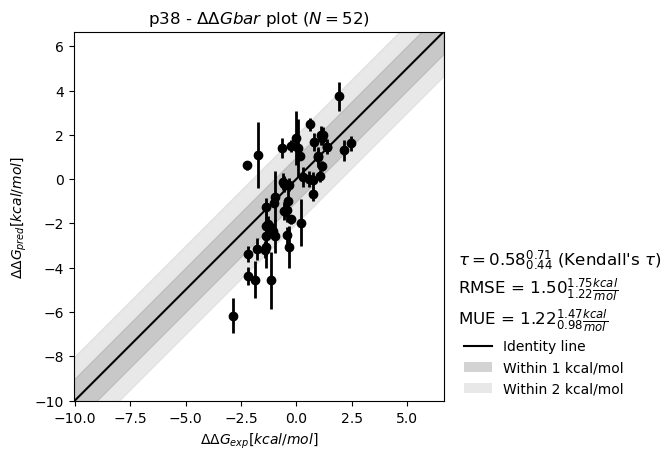

In [ ]:
json_results = json.loads(Path("results/p38/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results)
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="p38",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/p38/ligands.sdf")
network_dict = json.loads(Path("perturbations/p38/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2gg. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2q. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2t. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2l. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2ee. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2aa. Reindexed.
2025-04-23 16:28:54 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2o. 

## ptp1b

2025-04-23 16:28:59 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.41_{0.21}^{0.59}$ (Kendall's $\tau$) RMSE = $2.49_{1.73}^{3.18}  \frac{kcal}{mol}$ MUE = $1.86_{1.33}^{2.47}  \frac{kcal}{mol}$


Crashes:  0


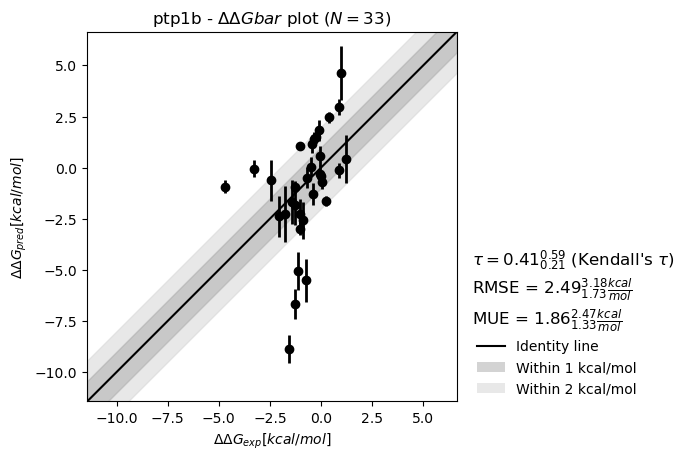

In [ ]:
json_results = json.loads(Path("results/ptp1b/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

### 2x Sampling

For `ptp1b`, we noticed outliers with very low energies for groups involving large perturbations. Therefore, we decided to run the same perturbation but with doubled sampling for each lambda step. The results we got are below:

2025-04-23 16:29:01 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.39_{0.2}^{0.58}$ (Kendall's $\tau$) RMSE = $1.89_{1.48}^{2.31}  \frac{kcal}{mol}$ MUE = $1.55_{1.21}^{1.95}  \frac{kcal}{mol}$


Crashes:  0


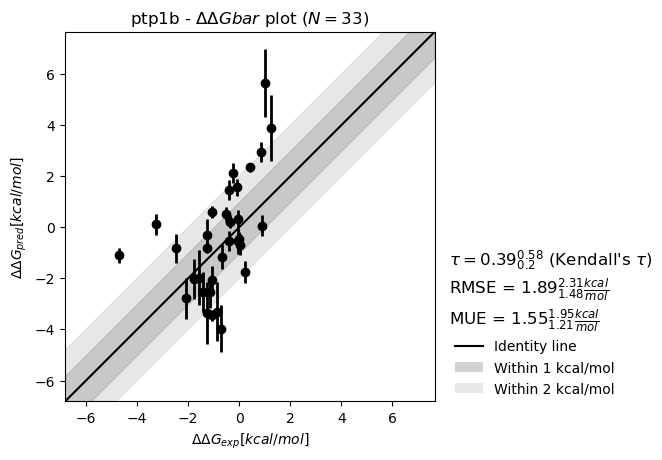

In [ ]:
json_results = json.loads(Path("results/ptp1b2xSampled/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="ptp1b",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/p38/ligands.sdf")
network_dict = json.loads(Path("perturbations/p38/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2gg. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2q. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2t. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2l. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2ee. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2aa. Reindexed.
2025-04-23 16:29:02 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 2o. 

## thrombin

2025-04-23 16:29:08 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.43_{-0.1}^{0.83}$ (Kendall's $\tau$) RMSE = $1.17_{0.83}^{1.47}  \frac{kcal}{mol}$ MUE = $1.04_{0.76}^{1.36}  \frac{kcal}{mol}$


Crashes:  0


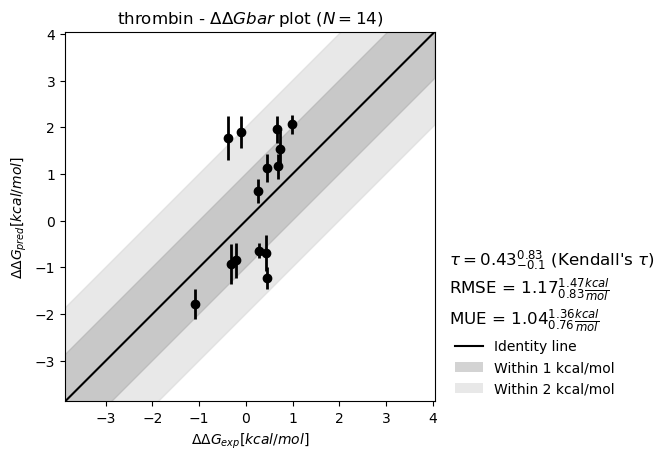

In [ ]:
json_results = json.loads(Path("results/thrombin/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="thrombin",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/thrombin/ligands.sdf")
network_dict = json.loads(Path("perturbations/thrombin/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6a. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 3a. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1d. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6e. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 6b. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-04-23 16:29:08 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1a. Rei

## tyk2

2025-04-23 16:29:11 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.32_{-0.06}^{0.61}$ (Kendall's $\tau$) RMSE = $1.21_{0.9}^{1.52}  \frac{kcal}{mol}$ MUE = $0.97_{0.68}^{1.28}  \frac{kcal}{mol}$


Crashes:  0


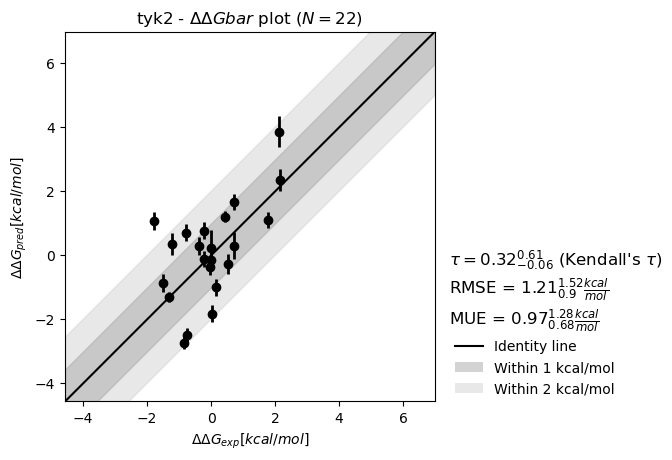

In [ ]:
json_results = json.loads(Path("results/tyk2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tyk2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/tyk2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tyk2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule jmc_23. Reindexed.
2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_47. Reindexed.
2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_49. Reindexed.
2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_45. Reindexed.
2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_44. Reindexed.
2025-04-23 16:29:11 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule ejm_43. Reindexed.
2025-04-23 16:29:12 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom l

# Merck

## cdk8

2025-04-23 16:29:15 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.14_{-0.08}^{0.34}$ (Kendall's $\tau$) RMSE = $3.41_{2.72}^{4.1}  \frac{kcal}{mol}$ MUE = $2.72_{2.16}^{3.3}  \frac{kcal}{mol}$


Crashes:  0


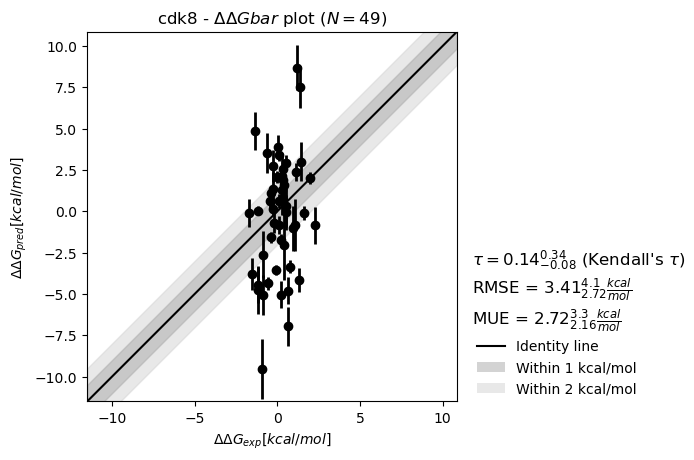

In [ ]:
json_results = json.loads(Path("results/cdk8/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

### Manual Mapping

For `cdk8`, we noticed a lot of the perturbations present in the automated mapping were difficult to accomplish. In this ligand set, two R-groups get perturbed at once, making it more prone for endpoint catastrophes. We decided to manually map the perturbations to avoid this. The results we got are below:

2025-04-23 16:29:17 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.24_{0.05}^{0.43}$ (Kendall's $\tau$) RMSE = $2.95_{2.43}^{3.47}  \frac{kcal}{mol}$ MUE = $2.35_{1.92}^{2.82}  \frac{kcal}{mol}$


Crashes:  0


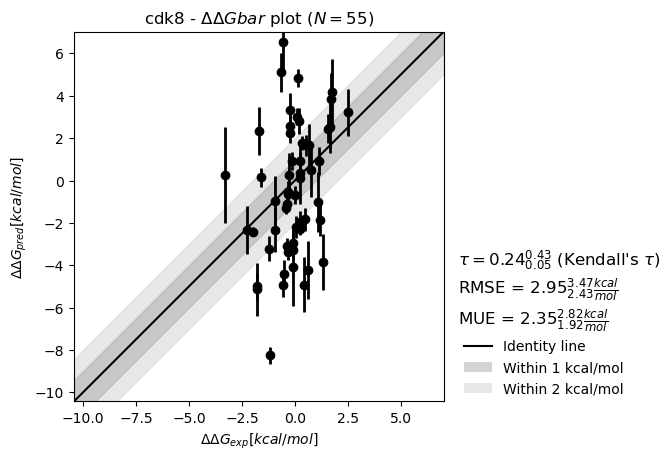

In [ ]:
json_results = json.loads(Path("results/cdk8ManualMapping/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cdk8",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/cdk8/ligands.sdf")
network_dict = json.loads(Path("perturbations/cdk8/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "hybridization_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## cmet

2025-04-23 16:29:23 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.44_{0.25}^{0.61}$ (Kendall's $\tau$) RMSE = $2.46_{1.77}^{3.09}  \frac{kcal}{mol}$ MUE = $1.93_{1.45}^{2.49}  \frac{kcal}{mol}$


Crashes:  0


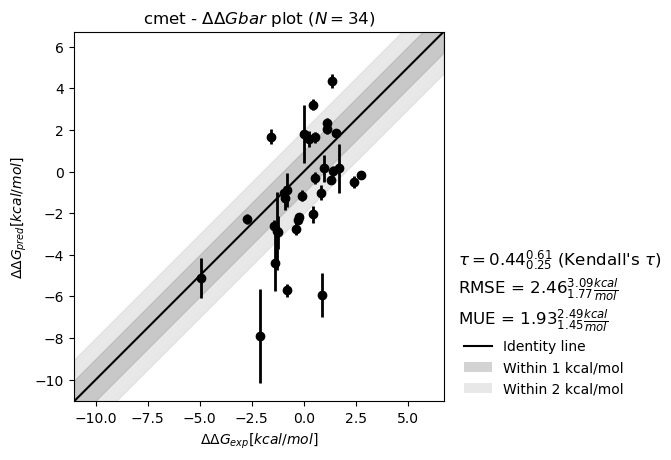

In [ ]:
json_results = json.loads(Path("results/cmet/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="cmet",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/cmet/ligands.sdf")
network_dict = json.loads(Path("perturbations/cmet/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## eg5

2025-04-23 16:29:28 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.31_{0.09}^{0.51}$ (Kendall's $\tau$) RMSE = $1.95_{1.55}^{2.34}  \frac{kcal}{mol}$ MUE = $1.61_{1.27}^{1.97}  \frac{kcal}{mol}$


Crashes:  0


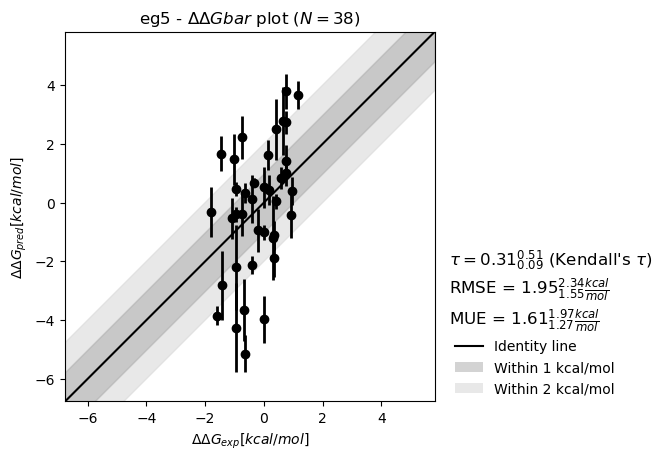

In [ ]:
json_results = json.loads(Path("results/eg5/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="eg5",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/eg5/ligands.sdf")
network_dict = json.loads(Path("perturbations/eg5/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## hif2a

2025-04-23 16:29:33 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.31_{0.14}^{0.46}$ (Kendall's $\tau$) RMSE = $2.07_{1.74}^{2.41}  \frac{kcal}{mol}$ MUE = $1.71_{1.42}^{2.0}  \frac{kcal}{mol}$


Crashes:  0


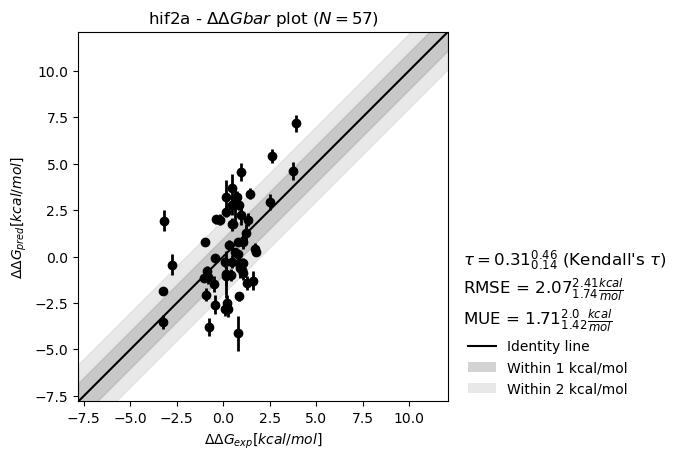

In [ ]:
json_results = json.loads(Path("results/hif2a/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="hif2a",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/hif2a/ligands.sdf")
network_dict = json.loads(Path("perturbations/hif2a/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## shp2

2025-04-23 16:29:39 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.60_{0.36}^{0.79}$ (Kendall's $\tau$) RMSE = $2.39_{1.8}^{2.88}  \frac{kcal}{mol}$ MUE = $2.06_{1.52}^{2.65}  \frac{kcal}{mol}$


Crashes:  0


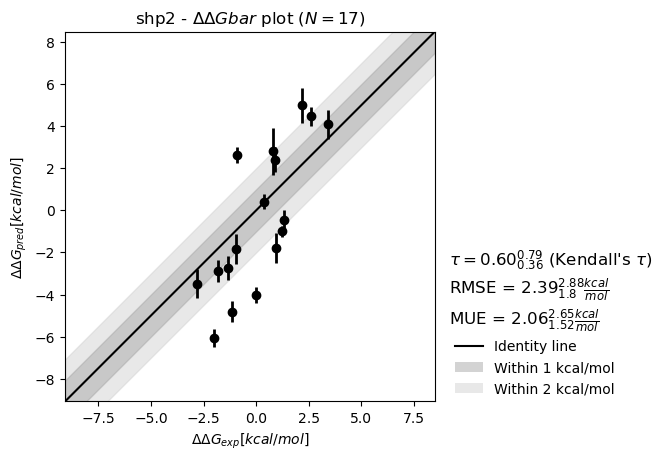

In [ ]:
json_results = json.loads(Path("results/shp2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="shp2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/shp2/ligands.sdf")
network_dict = json.loads(Path("perturbations/shp2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p_1.2"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:29:39 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-22. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 11. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-6. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-9. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule Example-8. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 7. Reindexed.
2025-04-23 16:29:40 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the at

## syk

2025-04-23 16:29:44 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.30_{0.1}^{0.49}$ (Kendall's $\tau$) RMSE = $1.26_{1.0}^{1.52}  \frac{kcal}{mol}$ MUE = $1.01_{0.82}^{1.23}  \frac{kcal}{mol}$


Crashes:  0


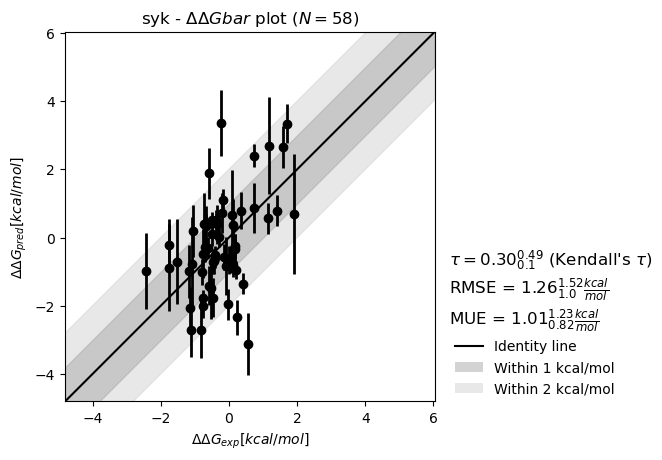

In [ ]:
json_results = json.loads(Path("results/syk/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="syk",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/syk/ligands.sdf")
network_dict = json.loads(Path("perturbations/syk/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## pfkfb3

2025-04-23 16:29:51 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.30_{0.1}^{0.49}$ (Kendall's $\tau$) RMSE = $1.70_{1.33}^{2.05}  \frac{kcal}{mol}$ MUE = $1.37_{1.09}^{1.67}  \frac{kcal}{mol}$


Crashes:  0


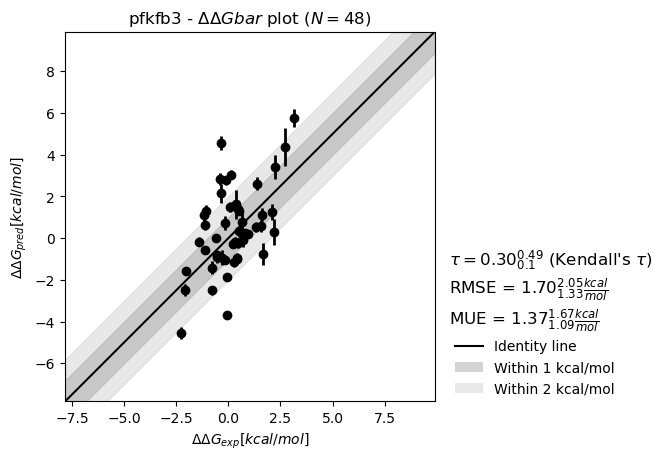

In [ ]:
json_results = json.loads(Path("results/pfkfb3/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="pfkfb3",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/pfkfb3/ligands.sdf")
network_dict = json.loads(Path("perturbations/pfkfb3/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "kartograf"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

## tnks2

2025-04-23 16:29:57 | INFO     | QligFEP.analyze_FEP:create_ddG_plot:620 - Stats: $\tau = 0.37_{0.11}^{0.6}$ (Kendall's $\tau$) RMSE = $1.24_{0.97}^{1.5}  \frac{kcal}{mol}$ MUE = $1.00_{0.76}^{1.24}  \frac{kcal}{mol}$


Crashes:  0


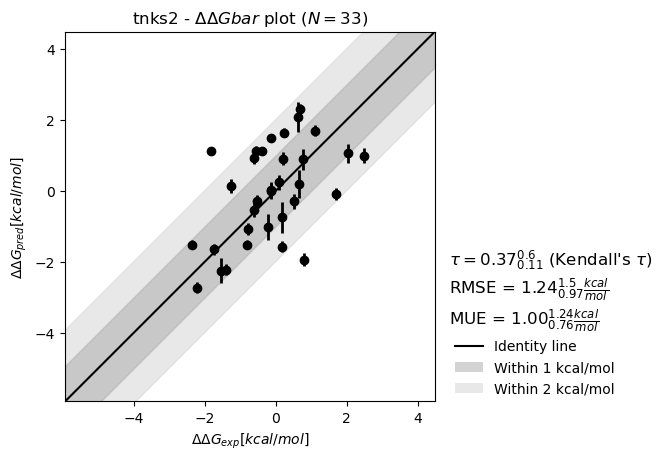

In [ ]:
json_results = json.loads(Path("results/tnks2/mapping_ddG.json").read_text())

df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()")
fig, ax = FepReader.create_ddG_plot(
    df.rename(columns={"from": "_from"}).reset_index(drop=True),
    target_name="tnks2",
)
print("Crashes: ", df.Q_ddG_avg.isna().sum())

In [ ]:
fep_names = {}

chemio = MoleculeIO("perturbations/tnks2/ligands.sdf")
network_dict = json.loads(Path("perturbations/tnks2/mapping.json").read_text())

edges = sorted([edge for edge in network_dict["edges"]], key=lambda x: x["from"])

for edge in edges:
    ligand1 = chemio[edge["from"]].to_rdkit()
    ligand2 = chemio[edge["to"]].to_rdkit()

    # Store both the ligand pairs and the name pairs
    fep_names[f"FEP_{edge['from']}_{edge['to']}"] = calculate_restraint_similarity(
        ligand1, ligand2, "heavyatom_p"
    )

df = df.merge(
    pd.DataFrame.from_dict(
        fep_names,
        orient="index",
        columns=["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings"],
    ).reset_index(names=["fep_name"]),
    how="left",
    on="fep_name",
)

all_dataframes.append(df)

2025-04-23 16:29:57 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 1b. Reindexed.
2025-04-23 16:29:58 | WARNING  | QligFEP.chemIO:_force_H_reindexing:116 - Hydrogens not at the end of the atom list for molecule 8b. Reindexed.


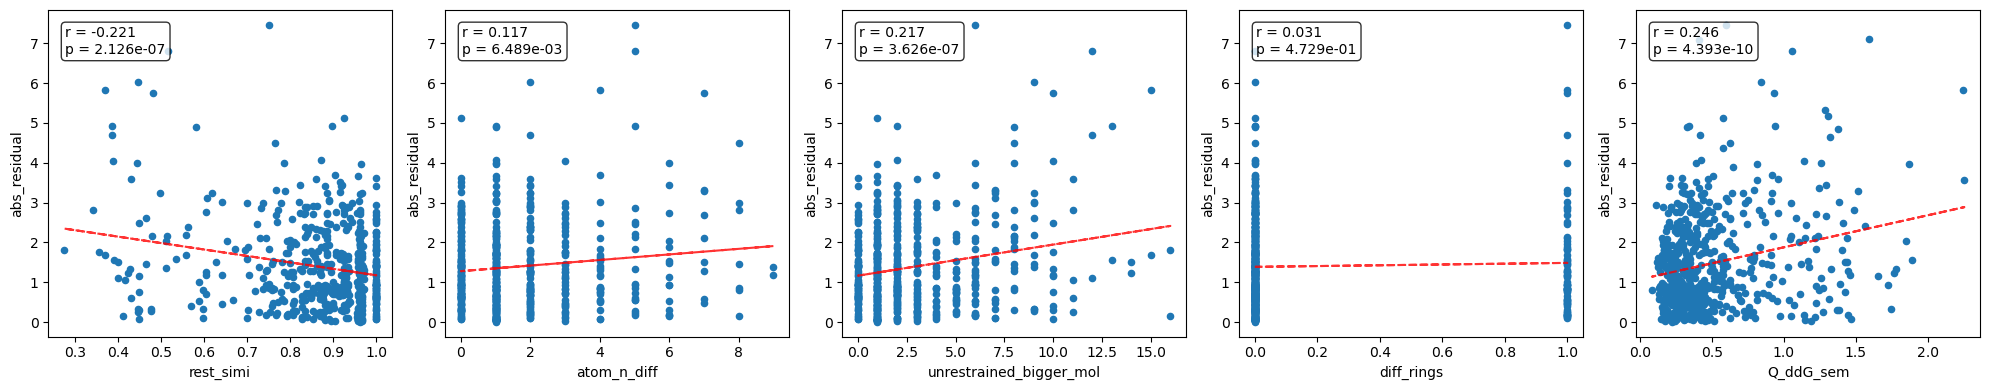

In [ ]:
alldata = pd.concat(all_dataframes, ignore_index=True)
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))

for i, (x_col, ax) in enumerate(
    zip(["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings", "Q_ddG_sem"], axs)
):
    alldata.assign(abs_residual=lambda x: x["residual"].abs()).plot.scatter(x=x_col, y="abs_residual", ax=ax)

    data = alldata[[x_col, "residual"]].dropna()
    x = data[x_col]
    y = data["residual"].abs()

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8)

    ax.text(
        0.05,
        0.95,
        f"r = {correlation:.3f}\np = {p_value:.3e}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

plt.tight_layout()

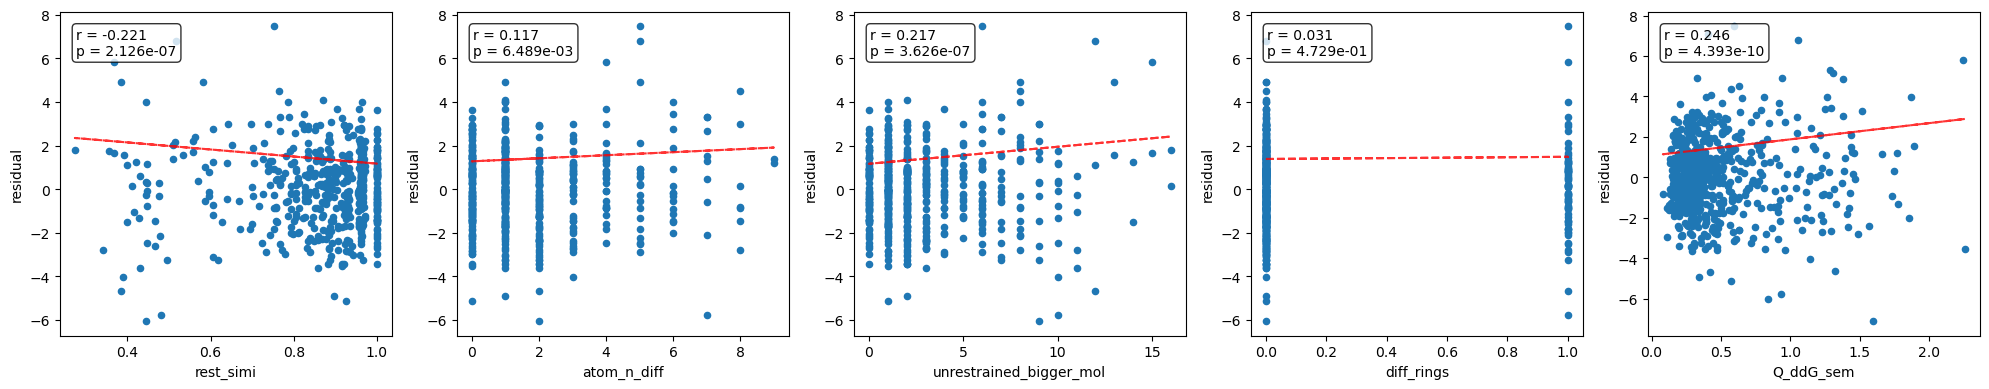

In [ ]:
alldata = pd.concat(all_dataframes, ignore_index=True)
fig, axs = plt.subplots(ncols=5, figsize=(20, 4))

for i, (x_col, ax) in enumerate(
    zip(["rest_simi", "atom_n_diff", "unrestrained_bigger_mol", "diff_rings", "Q_ddG_sem"], axs)
):
    alldata.assign(abs_residual=lambda x: x["residual"].abs()).plot.scatter(x=x_col, y="residual", ax=ax)

    data = alldata[[x_col, "residual"]].dropna()
    x = data[x_col]
    y = data["residual"].abs()

    correlation, p_value = stats.pearsonr(x, y)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.8)

    ax.text(
        0.05,
        0.95,
        f"r = {correlation:.3f}\np = {p_value:.3e}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

plt.tight_layout()

# Compare Results

## Imports & Functions

In [ ]:
def clean_latex_strings(text):
    """
    Find LaTeX-like strings with the form $value_{lower}^{upper}$
    and transform them by removing $, {, } symbols and replacing '^' with '_'.
    """
    pattern = r"\$([^\$_]+)_\{([^\}]+)\}\^\{([^\}]+)\}\$"

    def replacement(match):
        value, lower, upper = match.groups()
        return f"{value}_{lower}_{upper}"

    return re.sub(pattern, replacement, text)


def take_value(string, which="sub"):
    values = string.split("_")
    if which == "mean":
        return float(values[0])
    elif which == "sub":
        return float(values[1])
    elif which == "sup":
        return float(values[2])


def get_metrics_df(
    results_df: pd.DataFrame,
    statistics: list,
    targets: list,
    pred_col: str,
    exp_col: str,
):
    results_dict = {}
    for stat in statistics + ["N"]:
        dictionary = {stat: {}}
        for target in targets:
            subset = results_df.query("target == @target")
            if stat == "N":
                dictionary[stat][target] = len(subset)
                continue

            res = cstats.bootstrap_statistic(subset[pred_col].values, subset[exp_col].values, statistic=stat)

            def result_to_latex(res):
                # Round to one decimal
                mle = round(res["mle"], 1)
                low = round(res["low"], 1)
                high = round(res["high"], 1)

                # Generate the LaTeX string
                return f"${mle}_{{{low}}}^{{{high}}}$"

            latex = result_to_latex(res)
            dictionary[stat][target] = latex
        results_dict.update(dictionary)
    metrics_df = pd.DataFrame().from_dict(results_dict)
    return metrics_df

## Load our data

In [ ]:
jacs_targs = [
    "bace",
    "cdk2",
    "jnk1",
    "mcl1",
    "p38",
    "ptp1b2xSampled",
    "thrombin",
    "tyk2",
]
merck_targs = [
    "cdk8ManualMapping",
    "cmet",
    "eg5",
    "hif2a",
    "shp2",
    "syk",
    "pfkfb3",
    "tnks2",
]
targets = jacs_targs + merck_targs

In [ ]:
all_data = []

for targ in targets:
    fpath = Path(f"results/{targ}/mapping_ddG.json")
    if not fpath.exists():
        print(f"Skipping {targ}")
        continue

    json_results = json.loads(fpath.read_text())

    df = FepReader.prepare_df(json_results).query("~Q_ddG_avg.isna()").assign(target=targ)

    all_data.append(df)

all_data = pd.concat(all_data).assign(
    target=lambda x: x["target"].replace({"ptp1b2xSampled": "ptp1b", "cdk8ManualMapping": "cdk8"})
)
qligfep_metrics_df = get_metrics_df(
    all_data,
    ["KTAU", "RMSE", "MUE"],
    all_data.target.unique().tolist(),
    "Q_ddG_avg",
    "ddg_value",
)

## Fetch other data for comparison

In [ ]:
html_root = "https://raw.githubusercontent.com/dfhahn/protein-ligand-benchmark-analysis/refs/heads/master"

res = requests.get(f"{html_root}/03_comparison_experiment/03a_all_edges_all_ffs.csv")
res.raise_for_status()

hahn_results = pd.read_csv(StringIO(res.text), index_col=0).reset_index(names=["FEP_ID"])
targets = pd.Series(targets).replace({"ptp1b2xSampled": "ptp1b", "cdk8ManualMapping": "cdk8"}).tolist()

hahn_metrics_df = get_metrics_df(
    hahn_results,
    ["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="DDG_OpenFF-2.0",
    exp_col="DDG_Exp.",
)

### Shevsea

In [ ]:
from pathlib import Path

import pandas as pd

rootdir = Path("/zfsdata/data/david/qligfep-benchmark")
openff2results = [
    rootdir / "results/new_results_2/JACS/BACE/openFF2/BACE_ddG.csv",
    rootdir / "results/new_results_2/JACS/CDK2/openFF2/CDK2_ddG.csv",
    rootdir / "results/new_results_2/JACS/JNK1/openFF2/JNK1_ddG.csv",
    rootdir / "results/new_results_2/JACS/MCL1/openFF2/MCL1_ddG.csv",
    rootdir / "results/new_results_2/JACS/p38/openFF2/p38_ddG.csv",
    rootdir / "results/new_results_2/JACS/PTP1B/openFF2/PTP1B_ddG.csv",
    rootdir / "results/new_results_2/JACS/Thrombin/openFF2/Thrombin_ddG.csv",
    rootdir / "results/new_results_2/JACS/Tyk2/openFF2/Tyk2_ddG.csv",
    rootdir / "results/new_results_2/Merck/cdk8/openFF2/cdk8_ddG.csv",
    rootdir / "results/new_results_2/Merck/cmet/openFF2/cmet_ddG.csv",
    rootdir / "results/new_results_2/Merck/eg5/openFF2/eg5_ddG.csv",
    rootdir / "results/new_results_2/Merck/hif2a/openFF2/hif2a_ddG.csv",
    rootdir / "results/new_results_2/Merck/pfkfb3/openFF2/pfkfb3_ddG.csv",
    rootdir / "results/new_results_2/Merck/shp2/openFF2/shp2_ddG.csv",
    rootdir / "results/new_results_2/Merck/syk/openFF2/syk_ddG.csv",
    rootdir / "results/new_results_2/Merck/tnks2/openFF2/tnks2_ddG.csv",
]

opls2015results = [
    rootdir / "results/new_results_2/JACS/BACE/OPLS2015/BACE_ddG.csv",
    rootdir / "results/new_results_2/JACS/CDK2/OPLS2015/CDK2_ddG.csv",
    rootdir / "results/new_results_2/JACS/JNK1/OPLS2015/JNK1_ddG.csv",
    rootdir / "results/new_results_2/JACS/MCL1/OPLS2015/MCL1_ddG.csv",
    rootdir / "results/new_results_2/JACS/p38/OPLS2015/p38_ddG.csv",
    rootdir / "results/new_results_2/JACS/PTP1B/OPLS2015/PTP1B_ddG.csv",
    rootdir / "results/new_results_2/JACS/Thrombin/OPLS2015/Thrombin_ddG.csv",
    rootdir / "results/new_results_2/JACS/Tyk2/OPLS2015/Tyk2_ddG.csv",
    rootdir / "results/new_results_2/Merck/cdk8/OPLS2015/cdk8_ddG.csv",
    rootdir / "results/new_results_2/Merck/cmet/OPLS2015/cmet_ddG.csv",
    rootdir / "results/new_results_2/Merck/eg5/OPLS2015/eg5_ddG.csv",
    rootdir / "results/new_results_2/Merck/hif2a/OPLS2015/hif2a_ddG.csv",
    rootdir / "results/new_results_2/Merck/pfkfb3/OPLS2015/pfkfb3_ddG.csv",
    rootdir / "results/new_results_2/Merck/shp2/OPLS2015/shp2_ddG.csv",
    rootdir / "results/new_results_2/Merck/syk/OPLS2015/syk_ddG.csv",
    rootdir / "results/new_results_2/Merck/tnks2/OPLS2015/tnks2_ddG.csv",
]

openff2_shevsea = pd.concat(
    [pd.read_csv(_path).assign(target=_path.stem.split("_")[0]) for _path in openff2results],
    ignore_index=True,
).assign(target=lambda x: x["target"].str.lower())
opls_shevsea = pd.concat(
    [pd.read_csv(_path).assign(target=_path.stem.split("_")[0]) for _path in opls2015results],
    ignore_index=True,
).assign(target=lambda x: x["target"].str.lower())

shevsea_openff2_metrics_df = get_metrics_df(
    openff2_shevsea,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)
# shevsea_openff2_metrics_df.to_excel("shevsea_openff2.xlsx")

shevsea_opls_metrics_df = get_metrics_df(
    opls_shevsea,
    statistics=["KTAU", "RMSE", "MUE"],
    targets=targets,
    pred_col="Pred. ddG",
    exp_col="Exp. ddG",
)
# shevsea_opls_metrics_df.to_excel("shevsea_opls.xlsx")

## Aggregate and plot data

In [ ]:
all_results = pd.concat(
    [
        qligfep_metrics_df.assign(data="QligFEPv2 OpenFF 2.2.1"),
        shevsea_openff2_metrics_df.assign(data="QmapFEP OpenFF 2.0"),
        shevsea_opls_metrics_df.assign(data="QmapFEP OPLS-AA (2015)"),
        hahn_metrics_df.assign(data="Hahn et al. 2023 OpenFF 2.0"),
    ],
    ignore_index=False,
)

details_df = all_results.assign(
    RMSE=lambda x: x["RMSE"].apply(clean_latex_strings),
    MUE=lambda x: x["MUE"].apply(clean_latex_strings),
    KTAU=lambda x: x["KTAU"].apply(clean_latex_strings),
    RMSE_mean=lambda x: x["RMSE"].apply(partial(take_value, which="mean")),
    MUE_mean=lambda x: x["MUE"].apply(partial(take_value, which="mean")),
    KTAU_mean=lambda x: x["KTAU"].apply(partial(take_value, which="mean")),
    RMSE_sub=lambda x: x["RMSE"].apply(partial(take_value, which="sub")),
    MUE_sub=lambda x: x["MUE"].apply(partial(take_value, which="sub")),
    KTAU_sub=lambda x: x["KTAU"].apply(partial(take_value, which="sub")),
    RMSE_sup=lambda x: x["RMSE"].apply(partial(take_value, which="sup")),
    MUE_sup=lambda x: x["MUE"].apply(partial(take_value, which="sup")),
    KTAU_sup=lambda x: x["KTAU"].apply(partial(take_value, which="sup")),
)

/tmp/ipykernel_2637471/4041935341.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2637471/4041935341.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


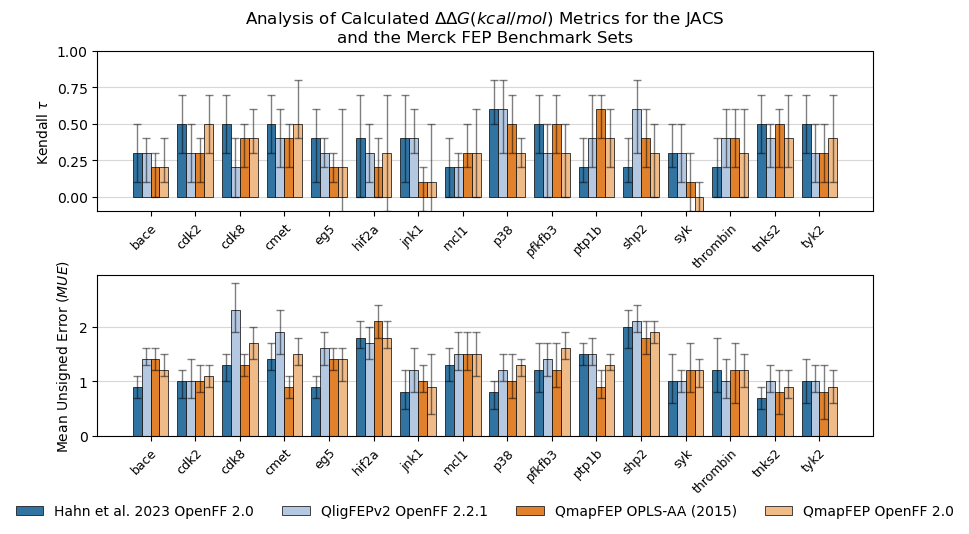

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

palette = "tab20"
fig, axs = plt.subplots(nrows=2, figsize=(10, 5))

toplot_data = (
    details_df.reset_index(names=["target"])
    .assign(target_data=lambda x: x["target"] + " " + x["data"])
    .rename(columns={"data": "ForceField"})
    .sort_values(["target", "ForceField"])
)

metrics = ["KTAU", "MUE"]

for ax, metric in zip(axs.flatten(), metrics):
    error_df = toplot_data[[f"{metric}_sub", f"{metric}_sup"]]
    lower_error = toplot_data[f"{metric}_mean"] - error_df[f"{metric}_sub"]
    upper_error = error_df[f"{metric}_sup"] - toplot_data[f"{metric}_mean"]
    error_values = np.array([lower_error, upper_error])

    barplot = sns.barplot(
        toplot_data,
        hue="ForceField",
        x="target",
        y=f"{metric}_mean",
        ax=ax,
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
    )
    for idx, bar in enumerate(barplot.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()

        try:
            yerr = [[error_values[0, idx]], [error_values[1, idx]]]
        except IndexError:
            break

        # Add error bars with the correct shape
        ax.errorbar(
            x_bar,
            y_bar,
            yerr=np.array(yerr).reshape(2, 1),
            color="black",
            fmt="none",
            elinewidth=1,
            capsize=3,
            alpha=0.5,
        )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=9,
    )
    if metric == "KTAU":
        ax.set_title(
            "Analysis of Calculated $ΔΔG (kcal/mol)$ Metrics for the JACS\nand the Merck FEP Benchmark Sets",
        )
        # ax.legend(bbox_to_anchor=(1.02, -0.45), loc="lower left", borderaxespad=0, frameon=False)
        ax.set_ylabel(r"Kendall $\tau$")
        ax.legend().set_visible(False)
        ax.set_ylim(-0.1, 1)
    elif metric == "MUE":
        # ax.legend().set_visible(False)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.35),
            frameon=False,
            shadow=True,
            ncol=5,
        )
        ax.set_ylabel("Mean Unsigned Error $(MUE)$")
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.savefig("all_metrics.svg", bbox_inches="tight")
plt.show()

/tmp/ipykernel_2637471/100228061.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_2637471/100228061.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


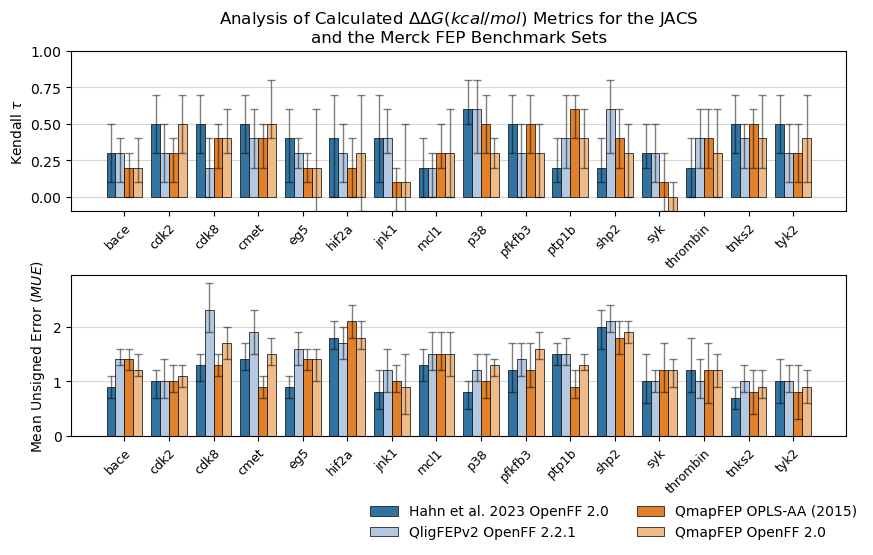

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

palette = "tab20"
fig, axs = plt.subplots(nrows=2, figsize=(10, 5))

toplot_data = (
    details_df.reset_index(names=["target"])
    .assign(target_data=lambda x: x["target"] + " " + x["data"])
    .rename(columns={"data": "ForceField"})
    .sort_values(["target", "ForceField"])
)

metrics = ["KTAU", "MUE"]

for ax, metric in zip(axs.flatten(), metrics):
    error_df = toplot_data[[f"{metric}_sub", f"{metric}_sup"]]
    lower_error = toplot_data[f"{metric}_mean"] - error_df[f"{metric}_sub"]
    upper_error = error_df[f"{metric}_sup"] - toplot_data[f"{metric}_mean"]
    error_values = np.array([lower_error, upper_error])

    barplot = sns.barplot(
        toplot_data,
        hue="ForceField",
        x="target",
        y=f"{metric}_mean",
        ax=ax,
        palette=palette,
        edgecolor="black",
        linewidth=0.5,
    )
    for idx, bar in enumerate(barplot.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()

        try:
            yerr = [[error_values[0, idx]], [error_values[1, idx]]]
        except IndexError:
            break

        # Add error bars with the correct shape
        ax.errorbar(
            x_bar,
            y_bar,
            yerr=np.array(yerr).reshape(2, 1),
            color="black",
            fmt="none",
            elinewidth=1,
            capsize=3,
            alpha=0.5,
        )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor",
        fontsize=9,
    )
    if metric == "KTAU":
        ax.set_title(
            "Analysis of Calculated $ΔΔG (kcal/mol)$ Metrics for the JACS\nand the Merck FEP Benchmark Sets",
        )
        # ax.legend(bbox_to_anchor=(1.02, -0.45), loc="lower left", borderaxespad=0, frameon=False)
        ax.set_ylabel(r"Kendall $\tau$")
        ax.legend().set_visible(False)
        ax.set_ylim(-0.1, 1)
    elif metric == "MUE":
        # ax.legend().set_visible(False)
        ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.7, -0.35),
            frameon=False,
            shadow=True,
            ncol=2,
        )
        ax.set_ylabel("Mean Unsigned Error $(MUE)$")
    ax.set_xlabel("")
    ax.grid(axis="y", alpha=0.5)
    ax.set_axisbelow(True)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
fig.savefig("all_metrics_2colLegend.svg", bbox_inches="tight")
plt.show()